<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 4 Sprint 3 Assignment 2*
# Convolutional Neural Networks (CNNs)

# Assignment

- <a href="#p1">Part 1:</a> Pre-Trained Model
- <a href="#p2">Part 2:</a> Custom CNN Model
- <a href="#p3">Part 3:</a> CNN with Data Augmentation


You will apply three different CNN models to a binary image classification model using Keras. Classify images of Mountains (`./data/mountain/*`) and images of forests (`./data/forest/*`). Treat mountains as the postive class (1) and the forest images as the negative (zero). 

|Mountain (+)|Forest (-)|
|---|---|
|![](./data/mountain/art1131.jpg)|![](./data/forest/cdmc317.jpg)|

The problem is realively difficult given that the sample is tiny: there are about 350 observations per class. This sample size might be something that you can expect with prototyping an image classification problem/solution at work. Get accustomed to evaluating several differnet possible models.

# Pre - Trained Model
<a id="p1"></a>

Load a pretrained network from Keras, [ResNet50](https://tfhub.dev/google/imagenet/resnet_v1_50/classification/1) - a 50 layer deep network trained to recognize [1000 objects](https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt). Starting usage:

```python
import numpy as np

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D()
from tensorflow.keras.models import Model # This is the functional API

resnet = ResNet50(weights='imagenet', include_top=False)

```

The `include_top` parameter in `ResNet50` will remove the full connected layers from the ResNet model. The next step is to turn off the training of the ResNet layers. We want to use the learned parameters without updating them in future training passes. 

```python
for layer in resnet.layers:
    layer.trainable = False
```

Using the Keras functional API, we will need to additional additional full connected layers to our model. We we removed the top layers, we removed all preivous fully connected layers. In other words, we kept only the feature processing portions of our network. You can expert with additional layers beyond what's listed here. The `GlobalAveragePooling2D` layer functions as a really fancy flatten function by taking the average of each of the last convolutional layer outputs (which is two dimensional still). 

```python
x = res.output
x = GlobalAveragePooling2D()(x) # This layer is a really fancy flatten
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(res.input, predictions)
```

Your assignment is to apply the transfer learning above to classify images of Mountains (`./data/mountain/*`) and images of forests (`./data/forest/*`). Treat mountains as the postive class (1) and the forest images as the negative (zero). 

Steps to complete assignment: 
1. Load in Image Data into numpy arrays (`X`) 
2. Create a `y` for the labels
3. Train your model with pretrained layers from resnet
4. Report your model's accuracy

## Load in Data

In [13]:
# https://www.tensorflow.org/tutorials/images/transfer_learning
# https://www.tensorflow.org/tutorials/load_data/images

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib
import IPython.display as display
from PIL import Image
import random 
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import preprocess_input

keras = tf.keras
AUTOTUNE = tf.data.experimental.AUTOTUNE
data_dir = "./data"
data_dir = pathlib.Path(data_dir)

In [109]:
# import glob
# labeled_files = []
# for file in glob.glob("./data/*/*.jpg"):
#     path = file.split("/")
#     label = path[2]
#     name = path[-1]
#     labeled_files.append((label, file, name))

# random.shuffle(labeled_files)

In [110]:
# train, test = train_test_split(labeled_files, test_size=0.20, random_state=42)
# test, validation = train_test_split(test, test_size=0.50, random_state=42)

In [111]:
# len(train), len(test), len(validation), len(labeled_files)

(561, 70, 71, 702)

In [112]:
# for label, path, name in train:
#     pathlib.Path(path).rename(f"./data/train/{label}/{name}")

In [113]:
# for label, path, name in test:
#     pathlib.Path(path).rename(f"./data/test/{label}/{name}")

In [114]:
# for label, path, name in validation:
#     pathlib.Path(path).rename(f"./data/validation/{label}/{name}")

In [16]:
train_dir = pathlib.Path("./data/train")
test_dir = pathlib.Path("./data/test")
validation_dir = pathlib.Path("./data/validation")

In [17]:
CLASS_NAMES = np.array([item.name for item in train_dir.glob('*') if item.name != ".ipynb_checkpoints"])
CLASS_NAMES

array(['forest', '.DS_Store', 'mountain'], dtype='<U9')

In [18]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [19]:
BATCH_SIZE = 32
IMG_HEIGHT = 160
IMG_WIDTH = 160

In [20]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return tf.cast(parts[-2] == 'mountain', tf.int32)


def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])


def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

        ds = ds.shuffle(buffer_size=shuffle_buffer_size)

        # Repeat forever
        ds = ds.repeat()

        ds = ds.batch(BATCH_SIZE)

        # `prefetch` lets the dataset fetch batches in the background while the model
        # is training.
        ds = ds.prefetch(buffer_size=AUTOTUNE)

        return ds



In [21]:
def load_images(data_dir):
    list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*.jpg'))
    labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    return prepare_for_training(labeled_ds)

In [22]:
train_batches = load_images(train_dir)
validation_batches = load_images(validation_dir)
test_batches = load_images(test_dir)

In [23]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 160, 160, 3])

In [199]:
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0], dtype=int32)>

## Instatiate Model

In [173]:
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

94773248/94765736 [==============================] - 64s 1us/step


In [200]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 2048)


In [201]:
base_model.trainable = False

In [202]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [203]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [204]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [205]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [206]:
initial_epochs = 10
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = np.ceil(70/BATCH_SIZE))

3/3 [==============================] - 5s 2s/step - loss: 0.7642 - accuracy: 0.4167


## Fit Model

In [ ]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches,
                   validation_steps = np.ceil(70/BATCH_SIZE),
                   steps_per_epoch = np.ceil(561/BATCH_SIZE))

Train for 18.0 steps, validate for 3.0 steps
Epoch 1/10
18/18 [==============================] - 40s 2s/step - loss: 0.6947 - accuracy: 0.5885 - val_loss: 0.7207 - val_accuracy: 0.4583
Epoch 2/10
18/18 [==============================] - 40s 2s/step - loss: 0.5496 - accuracy: 0.7101 - val_loss: 0.7240 - val_accuracy: 0.4375
Epoch 3/10
18/18 [==============================] - 35s 2s/step - loss: 0.4710 - accuracy: 0.7830 - val_loss: 0.7182 - val_accuracy: 0.4271
Epoch 4/10
18/18 [==============================] - 35s 2s/step - loss: 0.4032 - accuracy: 0.8507 - val_loss: 0.7072 - val_accuracy: 0.4479
Epoch 5/10
18/18 [==============================] - 35s 2s/step - loss: 0.3645 - accuracy: 0.8750 - val_loss: 0.7134 - val_accuracy: 0.4375
Epoch 6/10
18/18 [==============================] - 35s 2s/step - loss: 0.3222 - accuracy: 0.9062 - val_loss: 0.7132 - val_accuracy: 0.4167
Epoch 7/10
 9/18 [==============>...............] - ETA: 15s - loss: 0.2849 - accuracy: 0.9028

# Custom CNN Model

In this step, write and train your own convolutional neural network using Keras. You can use any architecture that suits you as long as it has at least one convolutional and one pooling layer at the beginning of the network - you can add more if you want. 

In [67]:
PATH = "./data/"
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [68]:
train_mountains_dir = os.path.join(train_dir, 'mountain')  # directory with our training cat pictures
train_forest_dir = os.path.join(train_dir, 'forest')  # directory with our training dog pictures
validation_mountains_dir = os.path.join(validation_dir, 'mountain')  # directory with our validation cat pictures
validation_forest_dir = os.path.join(validation_dir, 'forest') 

In [115]:
num_mountains_tr = len(os.listdir(train_mountains_dir))
num_forest_tr = len(os.listdir(train_forest_dir))

num_mountains_val = len(os.listdir(validation_mountains_dir))
num_forest_val = len(os.listdir(validation_forest_dir))

total_train = num_mountains_tr + num_forest_tr
total_val = num_mountains_val + num_forest_val

print('total training mountains images:', num_mountains_tr)
print('total training forest images:', num_forest_tr)

print('total validation mountains images:', num_mountains_val)
print('total validation forest images:', num_forest_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training mountains images: 299
total training forest images: 263
total validation mountains images: 40
total validation forest images: 31
--
Total training images: 562
Total validation images: 71


In [116]:
batch_size = 32
epochs = 50
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [117]:
train_image_generator = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    ) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [118]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 561 images belonging to 2 classes.


In [119]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 71 images belonging to 2 classes.


In [135]:
test_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 70 images belonging to 2 classes.


In [120]:
sample_training_images, _ = next(train_data_gen)

In [121]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

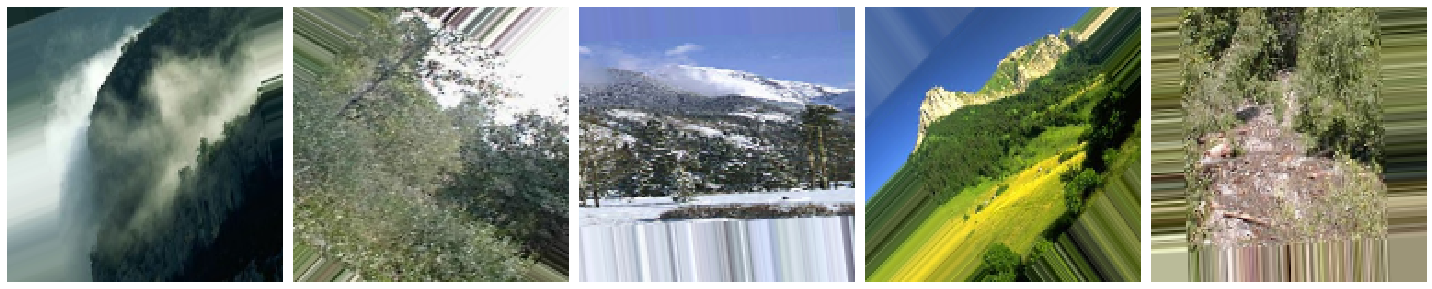

In [122]:
plotImages(sample_training_images[:5])

In [123]:
model_new = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

In [124]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [125]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 17 steps, validate for 2 steps
Epoch 1/50
17/17 [==============================] - 11s 629ms/step - loss: 0.1671 - accuracy: 0.9376 - val_loss: 0.2251 - val_accuracy: 0.9219
Epoch 2/50
17/17 [==============================] - 8s 498ms/step - loss: 0.1664 - accuracy: 0.9338 - val_loss: 0.1857 - val_accuracy: 0.9062
Epoch 3/50
17/17 [==============================] - 10s 599ms/step - loss: 0.1612 - accuracy: 0.9282 - val_loss: 0.2526 - val_accuracy: 0.8906
Epoch 4/50
17/17 [==============================] - 11s 628ms/step - loss: 0.1527 - accuracy: 0.9471 - val_loss: 0.1830 - val_accuracy: 0.9375
Epoch 5/50
17/17 [==============================] - 15s 908ms/step - loss: 0.1798 - accuracy: 0.9263 - val_loss: 0.2582 - val_accuracy: 0.8750
Epoch 6/50
17/17 [==============================] - 14s 843ms/step - loss: 0.1568 - accuracy: 0.9338 - val_loss: 0.2395 - val_accuracy: 0.8438
Epoch 7/50
17/17 [==============================] - 

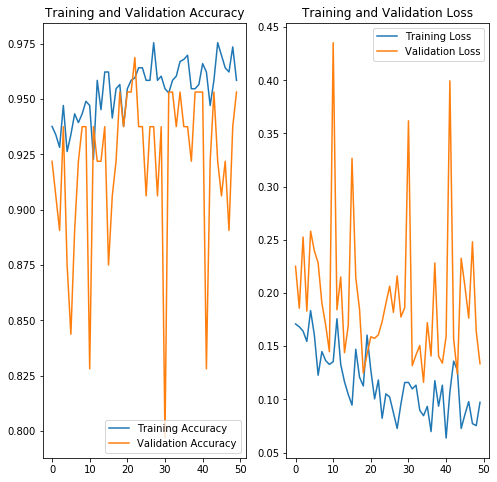

In [126]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [133]:
file_path = "./data/test/forest/for116.jpg"
label = get_label(file_path)
# load the raw data from the file as a string
img = tf.io.read_file(file_path)
# convert the compressed string to a 3D uint8 tensor
img = tf.image.decode_jpeg(img, channels=3)
# Use `convert_image_dtype` to convert to floats in the [0,1] range.
img = tf.image.convert_image_dtype(img, tf.float32)
# resize the image to the desired size.
img = tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

img = np.expand_dims(img, axis=0)

In [185]:
test_forests = glob.glob("./data/test/mountain/*.jpg")

In [186]:
len(test_forests)

35

In [182]:
predictions = []

In [187]:
for file_path in test_forests:
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    img = tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

    img = np.expand_dims(img, axis=0)
    predictions.append(int(model.predict(img) > 0) == 1)

In [189]:
np.mean(predictions), len(predictions)

(0.9571428571428572, 70)

# Custom CNN Model with Image Manipulations
## *This a stretch goal, and it's relatively difficult*

To simulate an increase in a sample of image, you can apply image manipulation techniques: cropping, rotation, stretching, etc. Luckily Keras has some handy functions for us to apply these techniques to our mountain and forest example. Check out these resources to help you get started: 

1. [Keras `ImageGenerator` Class](https://keras.io/preprocessing/image/#imagedatagenerator-class)
2. [Building a powerful image classifier with very little data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)
 

In [4]:
# State Code for Image Manipulation Here

# Resources and Stretch Goals

Stretch goals
- Enhance your code to use classes/functions and accept terms to search and classes to look for in recognizing the downloaded images (e.g. download images of parties, recognize all that contain balloons)
- Check out [other available pretrained networks](https://tfhub.dev), try some and compare
- Image recognition/classification is somewhat solved, but *relationships* between entities and describing an image is not - check out some of the extended resources (e.g. [Visual Genome](https://visualgenome.org/)) on the topic
- Transfer learning - using images you source yourself, [retrain a classifier](https://www.tensorflow.org/hub/tutorials/image_retraining) with a new category
- (Not CNN related) Use [piexif](https://pypi.org/project/piexif/) to check out the metadata of images passed in to your system - see if they're from a national park! (Note - many images lack GPS metadata, so this won't work in most cases, but still cool)

Resources
- [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) - influential paper (introduced ResNet)
- [YOLO: Real-Time Object Detection](https://pjreddie.com/darknet/yolo/) - an influential convolution based object detection system, focused on inference speed (for applications to e.g. self driving vehicles)
- [R-CNN, Fast R-CNN, Faster R-CNN, YOLO](https://towardsdatascience.com/r-cnn-fast-r-cnn-faster-r-cnn-yolo-object-detection-algorithms-36d53571365e) - comparison of object detection systems
- [Common Objects in Context](http://cocodataset.org/) - a large-scale object detection, segmentation, and captioning dataset
- [Visual Genome](https://visualgenome.org/) - a dataset, a knowledge base, an ongoing effort to connect structured image concepts to language